In [1]:
import pickle
import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from c3sdb.ml.data import C3SD
from c3sdb.ml.kmcm import kmcm_p_grid, KMCMulti
from c3sdb.ml.metrics import compute_metrics_train_test, train_test_summary_figure

In [2]:
def print_debug(message):
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] {message}")

In [3]:
start_time = time.time()

In [4]:
_SRC_TAGS = [
    "zhou1016", "zhou0817", "zhen0917", "pagl0314", "righ0218", "nich1118",
    "may_0114", "moll0218", "hine1217", "hine0217", "hine0817", "groe0815",
    "bijl0517", "stow0817", "hine0119", "leap0219", "blaz0818", "tsug0220",
    "lian0118", "teja0918", "pola0620", "dodd0220", "celm1120", "belo0321",
    "ross0422", "baker0524", "mull_1223", "palm_0424"
]

In [5]:
print_debug("Initializing the dataset.")
print_debug(f"Fetching these src tags: {_SRC_TAGS}")

data = C3SD("C3S_V2.db", datasets=_SRC_TAGS, seed=2345)


[2025-01-15 23:25:43] Initializing the dataset.
[2025-01-15 23:25:43] Fetching these src tags: ['zhou1016', 'zhou0817', 'zhen0917', 'pagl0314', 'righ0218', 'nich1118', 'may_0114', 'moll0218', 'hine1217', 'hine0217', 'hine0817', 'groe0815', 'bijl0517', 'stow0817', 'hine0119', 'leap0219', 'blaz0818', 'tsug0220', 'lian0118', 'teja0918', 'pola0620', 'dodd0220', 'celm1120', 'belo0321', 'ross0422', 'baker0524', 'mull_1223', 'palm_0424']


In [6]:
# Cell 6: Assemble features
print_debug("Assembling features.")

data.assemble_features(encoded_adduct=True, mqn_indices="all", handle_nan="drop")

[2025-01-15 23:25:45] Assembling features.
Added m/z
Added One-Hot Encoding Adducts
Added Polarization


In [7]:
data.show_features()
print(data.N_)

#num of entries that is assembles -> 15900 # unclean

Feature matrix (first 5 rows):
[[188.039277968 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
  16.898884431137727]
 [188.039277968 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
  16.898884431137727]
 [222.000305616 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
  17.804996407185634]
 [222.000305616 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
  17.804996407185634]
 [222.000305616 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
  17.804996407185634]]
15969


In [8]:
print_debug("Splitting the dataset into training and testing sets.")
data.train_test_split("ccs")

print_debug("Centering and scaling the data.")
data.center_and_scale()

print_debug("Saving encoder and scaler.")
data.save_encoder_and_scaler()

import numpy as np
valid_indices = ~np.isnan(data.X_train_ss_).any(axis=1)
data.X_train_ss_ = data.X_train_ss_[valid_indices]
data.y_train_ = data.y_train_[valid_indices]

# Drop rows with NaNs in test data
valid_test_indices = ~np.isnan(data.X_test_ss_).any(axis=1)
data.X_test_ss_ = data.X_test_ss_[valid_test_indices]
data.y_test_ = data.y_test_[valid_test_indices]


[2025-01-15 23:25:45] Splitting the dataset into training and testing sets.
[2025-01-15 23:25:45] Centering and scaling the data.
[2025-01-15 23:25:45] Saving encoder and scaler.


In [ ]:
#K-means parameter grid
kmcm_svr_p_grid_new = kmcm_p_grid([4], {"C": [1000, 10000], "gamma": [0.001, 0.1]}) #generates a parameter grid that can be used with GridSearchCV for hyperparameter tuning

#SVR
kmcm_svr_gs_new = GridSearchCV(KMCMulti(n_clusters=4, seed=2345, use_estimator=SVR(cache_size=1024, tol=1e-3)),
                           param_grid=kmcm_svr_p_grid_new, n_jobs=-1, cv=3, scoring="neg_mean_squared_error",
                           verbose=3)

In [10]:
#Run my model
kmcm_svr_gs_new.fit(data.X_train_ss_, data.y_train_)  
kmcm_svr_best_new = kmcm_svr_gs_new.best_estimator_   

Fitting 3 folds for each of 256 candidates, totalling 768 fits
[CV 2/3] END estimator_params=[{'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.001}], n_clusters=4;, score=-90.218 total time=  12.8s
[CV 3/3] END estimator_params=[{'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.001}], n_clusters=4;, score=-90.112 total time=  13.9s
[CV 1/3] END estimator_params=[{'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.001}], n_clusters=4;, score=-85.300 total time=  14.9s
[CV 1/3] END estimator_params=[{'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.1}], n_clusters=4;, score=-62.418 total time=  15.0s
[CV 2/3] END estimator_params=[{'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.001}, {'C': 1000, 'gamma': 0.1}], n_cluster

In [11]:
#Save the trained model
print_debug("Saving the trained model to 'c3sdb_kmcm_svr.pkl'.")

with open("c3sdb_kmcm_svr_new.pkl", "wb") as pf:
    pickle.dump(kmcm_svr_best_new, pf)

[2025-01-15 23:58:32] Saving the trained model to 'c3sdb_kmcm_svr.pkl'.


[2025-01-15 23:58:32] Computing predictions and metrics for the training data.
[2025-01-15 23:58:43] Computing predictions and metrics for the testing data.
[2025-01-15 23:58:46] Calculating performance metrics.
[2025-01-15 23:58:46] Generating summary figure and saving it


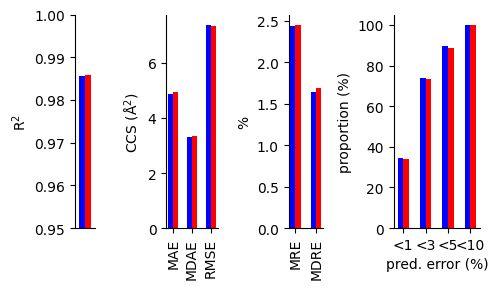

In [12]:
#My Model
# Running Inference
#Compute metrics for the trained model
print_debug("Computing predictions and metrics for the training data.")
y_pred_train = kmcm_svr_best_new.predict(data.X_train_ss_)

print_debug("Computing predictions and metrics for the testing data.")
y_pred_test = kmcm_svr_best_new.predict(data.X_test_ss_)

#Calculate performance metrics
print_debug("Calculating performance metrics.")
summary_new = compute_metrics_train_test(data.y_train_, data.y_test_, y_pred_train, y_pred_test)

#Generate summary figure
print_debug("Generating summary figure and saving it")
train_test_summary_figure(summary_new, "metrics_unclean_no_mqn.png")

In [13]:
import pandas as pd

model_stats_new = pd.DataFrame(summary_new)
model_stats_new.to_csv("metrics_unclean_no_mqn.csv")

ImportError: _multiarray_umath failed to import

In [14]:
#Record the end time and calculate the total runtime
end_time = time.time()
total_time = end_time - start_time
hours, remainder = divmod(total_time, 3600)
minutes, seconds = divmod(remainder, 60)
print_debug(f"Total runtime: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds.")


[2025-01-15 23:58:48] Total runtime: 0 hours, 33 minutes, 5 seconds.
